# **Data Cleaning Notebook**

## Objectives

- Assess and quantify missing data.
- Perform data cleaning to prepare for analysis and modeling.

## Inputs

- **Dataset**: outputs/datasets/collection/house_prices_records.csv

## Outputs

- Cleaned datasets ready for training and testing models.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Heritage-Housing-Issue/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Heritage-Housing-Issue'

# Load Data

In [4]:
import pandas as pd

# Load data from a CSV file into a DataFrame "df" and display the first five rows
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
    )
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

## Profile Report

We will explore the dataset for missing values. The code below will analyze the distribution and shape of a variable with missing data.

In [5]:
# Identify and list columns in "df" that have missing values.
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

Now that we"ve isolated the variable with missing data, let's generate a profile report to further investigate the characteristics of this missing data.

In [6]:
from ydata_profiling import ProfileReport

# Check if there are any columns with missing data.
if vars_with_missing_data:
    # Generate a minimal profile report for columns with missing data using Pandas Profiling
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    # Display the report
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analysis

We will conduct another round of correlation and Power Predictive Score (PPS) analysis to further explore and understand the relationships between the variables.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap="viridis", annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap="rocket_r", annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor="grey")
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(["x", "y", "ppscore"]).pivot(columns="x", index="y", values="ppscore")

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(["ppscore"]).describe().T
  print("PPS threshold - check PPS score IQR to decide the threshold for the heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Predictive power Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide the threshold for the heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



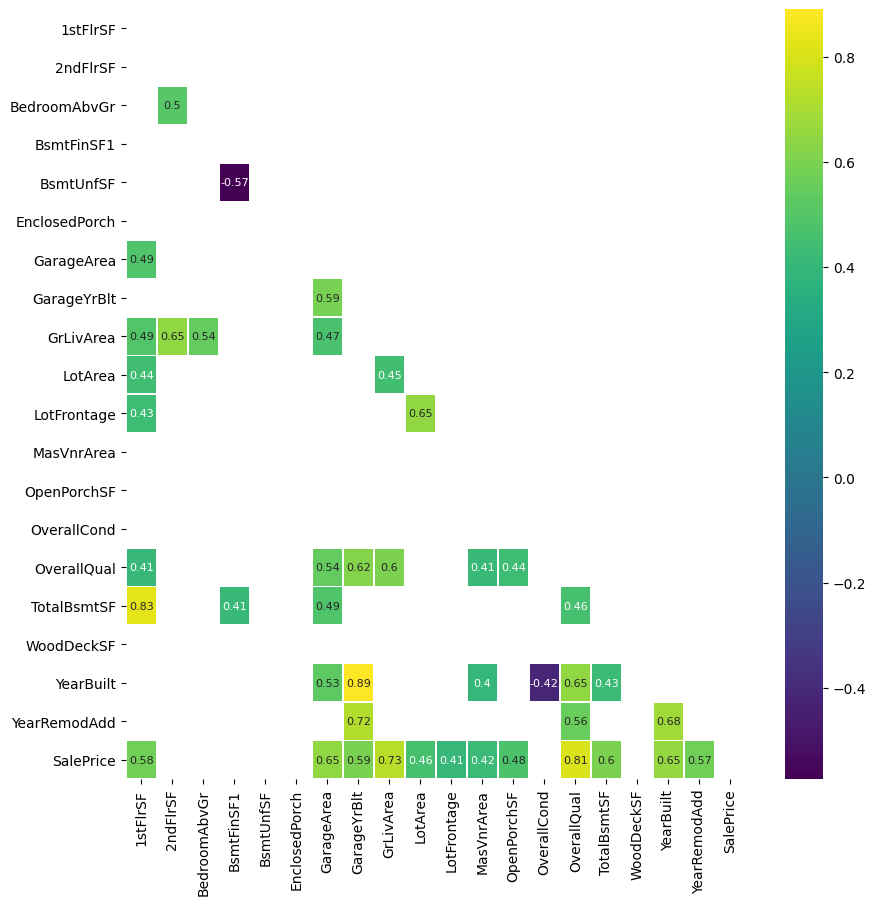



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



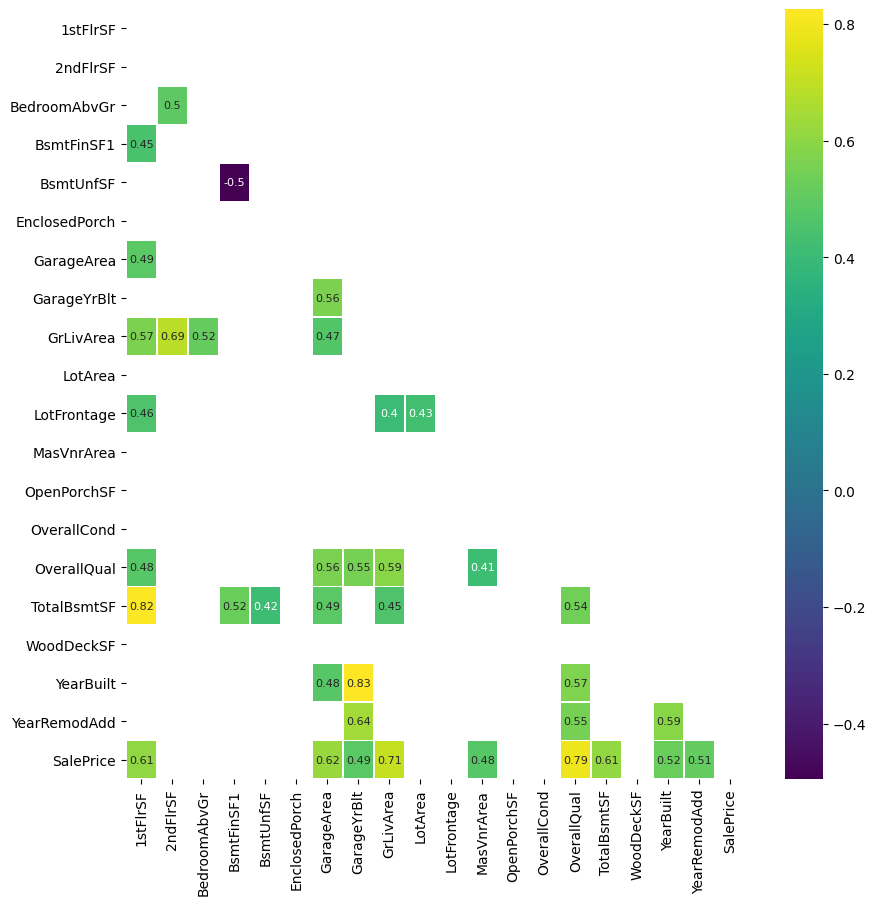



*** Heatmap: Predictive power Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



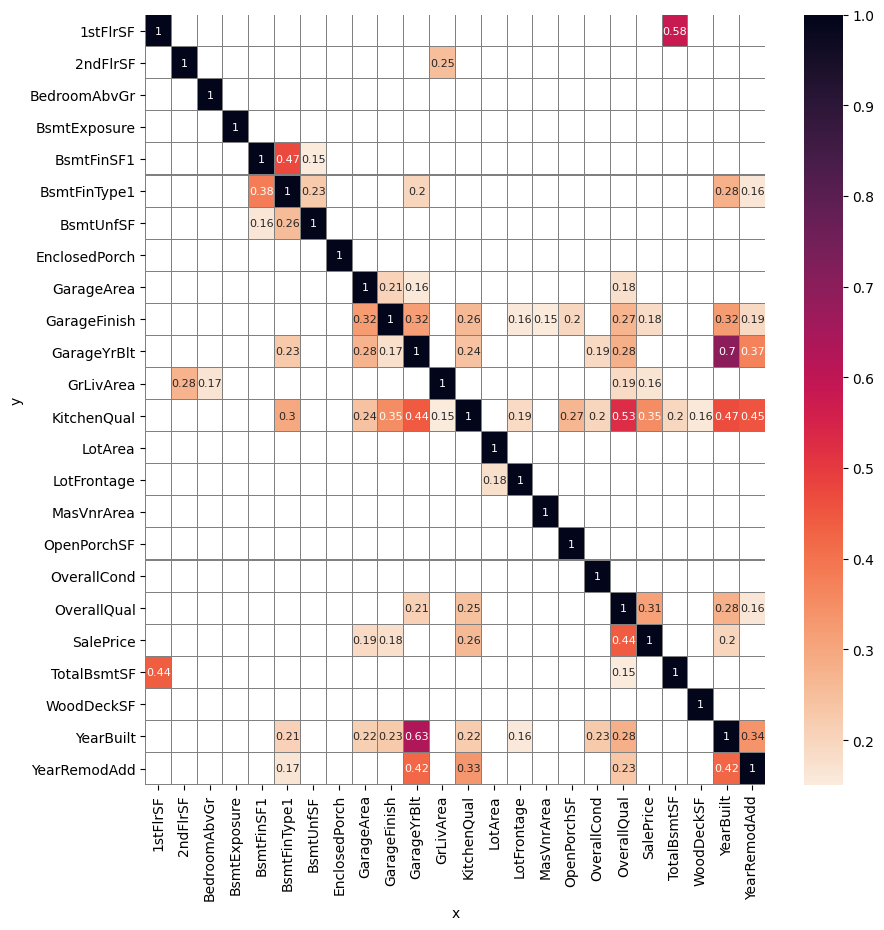

In [9]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman, 
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.4, PPS_Threshold=0.15,
                  figsize=(10,10), font_annot=8)

## Missing Values Analysis

We will conduct a concise evaluation of missing data, providing a shorter overview than the extensive report generated by pandas profiling.

In [10]:
def EvaluateMissingData(df):
    # Calculate the absolute number of missing entries for each column in the DataFrame
    missing_data_absolute = df.isnull().sum()
    # Calculate the percentage of missing data relative to the total dataset size
    missing_data_percentage = round(missing_data_absolute / len(df) * 100, 2)

    # Create a DataFrame to store the count of missing data, its percentage, and data type for each column
    df_missing_data = (pd.DataFrame(
        data={
            "RowsWithMissingData": missing_data_absolute,
            "PercentageOfDataset": missing_data_percentage,
            "DataType": df.dtypes
        })
        .sort_values(by=["PercentageOfDataset"], ascending=False)
        .query("PercentageOfDataset > 0")
    )

    # Check if the resulting DataFrame is empty, indicating no missing data
    if df_missing_data.empty:
        print("There are no variables with missing data")
    else:
        return df_missing_data

In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


Here"s a concise summary of the strategies for handling missing data for each variable in order of appearance:

- **EnclosedPorch** - (90.68% missing data): <br>
This variable will be dropped due to a high percentage of missing data.

- **WoodDeckSF** - (89.38% missing data): <br>
Similarly, this variable will be dropped due to the extensive missing data.

- **LotFrontage** - (17.74% missing data):
    - Exhibits a moderate correlation with Sale Price but lacks predictive power.
    - Imputation with the median (69) is considered, as 0 is not a logical fill for property street frontage. The mean is 70, showing a right skew.

- **GarageFinish** - (11.10% missing data):
    - This categorical variable includes values: Unfinished (unf), Rough Finished (rfn), Finished (fin), and None.
    - Missing values will be checked against garage area; "None" will be imputed if no garage area is present, otherwise most likely "Unfinished".

- **BsmtFinType1** - (7.81% missing data):
    - Similar to the approach for GarageFinish, inspect properties with missing values to determine if there is any basement area, and assign "None" if applicable.
    - Additional analysis will be necessary to address this variable further.

- **BedroomAbvGr** - (6.78% missing data):
    - Only 6 entries, representing 0.4% of the dataset, have a value of 0 for bedrooms above grade. This suggests that the missing data is unlikely to be attributable to the absence of bedrooms above grade.
    - Median and mean values are 3 and 2.9 respectively.

- **2ndFlrSF** - (5.89% missing data):
    - Zero can be assigned to properties with no second floor, as 53.5% of the dataset already has a value of 0 for this variable.

- **GarageYrBlt** - (5.55% missing data):
    - Highly correlated with the year built, suggesting it could often be the same as the construction year.
    - Missing values might be substituted with the year built where logical.
    - If both GarageFinish and GarageArea have a value of "None" and "0" respectively, it is likely that the property does not have a garage.

- **MasVnrArea** - (0.55% missing data):
    - The absence of values for MasVnrArea could indicate that there is no masonry veneer, especially since 59% of the values are 0, which is also the median value.

---

# Data Cleaning

## Create a Duplicate Dataset for Cleaning

First, we"ll create a copy of the dataset and apply the cleaning procedures to this copy:

In [12]:
# Create a copy of the "df" DataFrame
df_cleaned = df.copy()
df_cleaned

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694.0,3.0,No,0,Unf,953,NaN,460,RFn,...,62.0,0.0,40,5,6,953,0.0,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,NaN,500,Unf,...,85.0,119.0,0,6,6,1542,NaN,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,NaN,252,RFn,...,66.0,0.0,60,9,7,1152,NaN,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,112.0,240,Unf,...,68.0,0.0,0,6,5,1078,NaN,1950,1996,142125


## Handling Missing Data

In this section, we will examine and address missing data by analyzing its relationship with other relevant variables and making appropriate adjustments.

### **EnclosedPorch** and **WoodDeckSF**

As mentioned in the initial analysis, a significant amount of data for these variables is missing (90.68% and 89.38% respectively). Therefore we will drop these variables.

In [13]:
# Drop specified columns from the cleaned dataframe
df_cleaned = df_cleaned.drop(columns=["EnclosedPorch", "WoodDeckSF"])

We verify that the specified variables have been successfully removed from the dataframe with the code below:

In [14]:
# Print all variables with missing data to verify that the specified variables have been successfully removed
EvaluateMissingData(df_cleaned)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


As illustrated, the variables **EnclosedPorch** and **WoodDeckSF** no longer appear in the list of variables with missing data, confirming their successful removal from the dataset.

### **LotFrontage**

**LotFrontage** measures the linear feet of street frontage connected to a property, and logically, this value cannot be zero. A review of the dataset confirms there are no zero values.

The following code block is designed to identify and count the rows where **LotFrontage** is missing in the dataset:

In [15]:
# Identify rows in "df_cleaned" where "LotFrontage" is missing.
missing_lotfrontage = df_cleaned[df_cleaned["LotFrontage"].isnull()]

# Print the total number of rows with missing "LotFrontage" data
print(f"Amount of rows with missing data: {len(missing_lotfrontage)}")

# Display the DataFrame rows where "LotFrontage" is missing
missing_lotfrontage

Amount of rows with missing data: 259


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
7,1107,983.0,3.0,Mn,859,ALQ,216,484,NaN,1973.0,...,10382,NaN,240.0,204,6,7,1107,1973,1973,200000
12,912,0.0,2.0,No,737,ALQ,175,352,NaN,1962.0,...,12968,NaN,0.0,0,6,5,912,1962,1962,144000
14,1253,0.0,NaN,No,733,BLQ,520,352,RFn,1960.0,...,10920,NaN,212.0,213,5,6,1253,1960,1960,157000
16,1004,0.0,2.0,No,578,ALQ,426,480,Fin,1970.0,...,11241,NaN,180.0,0,7,6,1004,1970,1970,149000
24,1060,0.0,3.0,Mn,188,Rec,204,270,Unf,1968.0,...,8246,NaN,0.0,90,8,5,1060,1968,2001,154000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1440,0.0,3.0,No,678,BLQ,762,467,Fin,1981.0,...,12546,NaN,310.0,0,7,6,1440,1981,1981,182900
1431,958,0.0,2.0,No,958,LwQ,0,440,RFn,1976.0,...,4928,NaN,0.0,60,6,6,958,1976,1976,143750
1441,848,0.0,1.0,Av,697,GLQ,151,420,RFn,2004.0,...,4426,NaN,147.0,0,5,6,848,2004,2004,149300
1443,952,0.0,2.0,No,0,Unf,952,192,Unf,1916.0,...,8854,NaN,0.0,98,6,6,952,1916,1950,121000


The right-skewed distribution shown in the histogram from the Pandas Profile Report suggests that using the median for imputation is more appropriate than the mean.

In [16]:
# Calculate the median value of "LotFrontage" from the cleaned data
median_lot_frontage = df_cleaned["LotFrontage"].median()
print(f"Median value is: {median_lot_frontage}")

# Fill missing values in "LotFrontage" with the median value
df_cleaned["LotFrontage"].fillna(median_lot_frontage, inplace=True)
print("Filled the missing data with the median value")

# Verify the changes by checking for any remaining null values in the "LotFrontage" column
print(f'Variables with missing "Lot Frontage" value: {df_cleaned["LotFrontage"].isnull().sum()}')

Median value is: 69.0
Filled the missing data with the median value
Variables with missing "Lot Frontage" value: 0


### **GarageFinish**

**GarageFinish** refers to the interior finish of the garage, categorized by values such as "Unf" (Unfinished), "RFn" (Rough Finished), "Fin" (Finished), and "None" (No Garage).

The following code block is designed to identify and count the rows where **GarageFinish** is missing in the dataset:

In [17]:
# Identify rows in "df_cleaned" where "GarageFinish" is missing
missing_garage_finish = df_cleaned[df_cleaned["GarageFinish"].isnull()]

# Print the total number of rows with missing "GarageFinish" data
print(f"Amount of rows with missing data: {len(missing_garage_finish)}")

# Display specific columns related to the garage
missing_garage_finish[["GarageFinish", "GarageYrBlt", "GarageArea"]]

Amount of rows with missing data: 162


,GarageFinish,GarageYrBlt,GarageArea
7,NaN,1973.0,484
12,NaN,1962.0,352
23,NaN,1976.0,572
27,NaN,2008.0,772
35,NaN,2004.0,691
...,...,...,...
1401,NaN,2004.0,398
1415,NaN,2007.0,660
1438,NaN,1957.0,923
1442,NaN,2008.0,812


We will initially inspect properties to identify those that lack a garage, indicated by a **GarageArea** of 0. <br>

In [18]:
# Identify rows in "df_cleaned" where "GarageFinish" is missing and "GarageArea" is zero
df_no_garage_area = df_cleaned[(df_cleaned["GarageFinish"].isnull()) & (df["GarageArea"] == 0)]

# Print the total number of rows where "GarageFinish" is missing and there is no garage area
print(f"Amount of rows with missing data: {len(df_no_garage_area)}")

# Display specific columns related to the garage
df_no_garage_area[["GarageFinish", "GarageYrBlt", "GarageArea"]]

Amount of rows with missing data: 8


,GarageFinish,GarageYrBlt,GarageArea
125,NaN,NaN,0
431,NaN,NaN,0
528,NaN,NaN,0
649,NaN,NaN,0
710,NaN,NaN,0
1173,NaN,NaN,0
1323,NaN,NaN,0
1325,NaN,NaN,0


For these properties, we will impute the **GarageFinish** attribute as "None".

In [19]:
# Count initial number of properties without a garage ("GarageArea" is 0) and missing "GarageFinish"
initial_count = df_cleaned[(df_cleaned["GarageArea"] == 0) & (df_cleaned["GarageFinish"].isnull())].shape[0]
print(f'Initial number of rows with "GarageFinish" missing and no "GarageArea" value: {initial_count}')

# Assign the value "None" to "GarageFinish" for properties where "GarageArea" is 0
df_cleaned.loc[(df_cleaned["GarageArea"] == 0) & (df_cleaned["GarageFinish"].isnull()), "GarageFinish"] = "None"

# Count the number of properties that still have missing "GarageFinish" after the update
remaining_count = df_cleaned[(df_cleaned["GarageArea"] == 0) & (df_cleaned["GarageFinish"].isnull())].shape[0]
print(f'Remaining number of rows with "GarageFinish" missing and no "GarageArea" value after update: {remaining_count}')

Initial number of rows with "GarageFinish" missing and no "GarageArea" value: 8
Remaining number of rows with "GarageFinish" missing and no "GarageArea" value after update: 0


For the remaining properties that have a specified **GarageArea** but missing **GarageFinish**, we will impute the value "Unf", which is the most frequently occurring category for this variable.

In [20]:
# Display the amount of rows with missing "GarageFinish" values
print(f'Initial number of rows with "GarageFinish" missing: {df_cleaned["GarageFinish"].isnull().sum()}')

# Impute missing "GarageFinish" values with "Unf" (Unfinished)
df_cleaned.loc[(df_cleaned["GarageFinish"].isnull()), "GarageFinish"] = "Unf"

# Check and display the number of remaining missing entries in "GarageFinish" after imputation
print(f'Remaining missing "GarageFinish" entries: {df_cleaned["GarageFinish"].isnull().sum()}')

Initial number of rows with "GarageFinish" missing: 154
Remaining missing "GarageFinish" entries: 0


### **BsmtFinType1**

**BsmtFinType1** refers to the quality of the basement finish, categorized by values such as "GLQ" (Good Living Quarters), "ALQ" (Average Living Quarters), "BLQ" (Below Average Living Quarters), "Rec" (Average Recreational Room), "LwQ" (Low Quality), "Unf" (Unfinished), and "None" (No Basement).


The following code block is designed to identify and count the rows where **BsmtFinType1** is missing in the dataset:

In [21]:
# Identifying and counting the  missing entries for the "BsmtFinType1" column in the cleaned DataFrame
missing_bsmtfin_type1 = df_cleaned[df_cleaned["BsmtFinType1"].isnull()]

# Printing the number of rows with missing "BsmtFinType1" data
print(f"Amount of rows with missing data: {len(missing_bsmtfin_type1)}")

# Displaying specific columns of interest from rows with missing "BsmtFinType1"
missing_bsmtfin_type1[["BsmtFinType1", "TotalBsmtSF", "BsmtUnfSF", "BsmtFinSF1"]]

Amount of rows with missing data: 114


,BsmtFinType1,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1
11,NaN,1175,177,998
22,NaN,1777,1777,0
26,NaN,900,180,234
55,NaN,1425,935,490
89,NaN,990,402,588
...,...,...,...,...
1415,NaN,1386,398,988
1423,NaN,697,697,0
1435,NaN,1319,1319,0
1446,NaN,1188,595,593


Evaluate the missing values for **BsmtFinType1** where **TotalBsmtSF** is zero. Properties with a basement square footage of zero indicate no basement present, which justifies setting **BsmtFinType1** to "None".

In [22]:
# Identifying and counting the missing entries for the "BsmtFinType1" column in the cleaned DataFrame with a "TotalBsmtSF" value of 0
df_basement_none = df_cleaned[(df["BsmtFinType1"].isnull()) & (df["TotalBsmtSF"] == 0)]

# Printing the number of rows
print(f"Amount of rows with missing data: {len(df_basement_none)}")
df_basement_none[["BsmtFinType1", "TotalBsmtSF", "BsmtUnfSF", "BsmtFinSF1", "BsmtExposure"]]

Amount of rows with missing data: 6


,BsmtFinType1,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,BsmtExposure
90,NaN,0,0,0,None
182,NaN,0,0,0,None
362,NaN,0,0,0,None
736,NaN,0,0,0,None
1049,NaN,0,0,0,None
1179,NaN,0,0,0,None


The rows above display zero values for finished, unfinished, and total basement area, and also lack **BsmtExposure**. This confirms the absence of a basement, allowing us to confidently impute "None" for **BsmtFinType1**.

Let's proceed to impute these values now:

In [23]:
# Update "BsmtFinType1" to "None" for rows where there is no basement ("TotalBsmtSF" is 0)
df_cleaned.loc[(df_cleaned["TotalBsmtSF"] == 0) & (df_cleaned["BsmtFinType1"].isnull()), "BsmtFinType1"] = "None"

# Display the remaining number of rows that still have missing "BsmtFinType1" data
print(f'Amount of rows left with missing "BsmtFinType1" data: {df_cleaned["BsmtFinType1"].isnull().sum()}')

Amount of rows left with missing "BsmtFinType1" data: 108


There are 108 rows remaining with missing **BsmtFinType1** data.

The values belows indicate that the variable **BsmtUnfSF** has 0 square feet unfinished, and since the **TotalBsmtSF** is greater than 0, it suggests the basement is finished but no category has been assigned.

As we cannot deduce if it is a rec room/living quarter and the quality, we should create a new category: "Finished".

In [24]:
# Rows where "BsmtFinType1' is missing and 'BsmtUnfSF' equals 0
df_basement_finished = df_cleaned[(df_cleaned["BsmtFinType1"].isnull()) & (df["BsmtUnfSF"] == 0)]

# Printing the count of rows where basement finishing type is missing but there is no unfinished space
print(f"Amount of rows with missing data: {len(df_basement_finished)}")

# Displaying the selected columns for the filtered rows
df_basement_finished[["BsmtFinType1", "TotalBsmtSF", "BsmtUnfSF", "BsmtFinSF1"]]

Amount of rows with missing data: 6


,BsmtFinType1,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1
251,NaN,1573,0,1573
592,NaN,816,0,816
942,NaN,1440,0,1440
954,NaN,945,0,945
1163,NaN,1198,0,1198
1458,NaN,1078,0,49


Let's proceed to impute "Fin" value now to these rows:

In [25]:
# Update "BsmtFinType1" to "Fin" for rows where there is a value of "0" for "BsmtUnfSF"
df_cleaned.loc[(df_cleaned["BsmtFinType1"].isnull()) & (df["BsmtUnfSF"] == 0), "BsmtFinType1"] = "Fin"

# Display the remaining number of rows that still have missing 'BsmtFinType1' data
print(f'Amount of rows left with missing "BsmtFinType1" data: {df_cleaned["BsmtFinType1"].isnull().sum()}')

Amount of rows left with missing "BsmtFinType1" data: 102


There are still 102 rows missing data for **BsmtFinType1**.

In cases where the unfinished basement square footage (**BsmtUnfSF**) is greater than 0, we can reasonably impute these entries as 'Unfinished'.

In [26]:
# Select rows where "BsmtFinType1" is missing and "BsmtUnfSF" is greater than 0
df_basement_unfinished = df_cleaned[(df_cleaned["BsmtFinType1"].isnull()) & (df["BsmtUnfSF"] > 0)]

# Print the number of rows found with these conditions
print(f"Amount of rows with missing data: {len(df_basement_unfinished)}")

# Display the relevant columns for these rows to review the data
df_basement_unfinished[["BsmtFinType1", "TotalBsmtSF", "BsmtUnfSF", "BsmtFinSF1"]]

Amount of rows with missing data: 102


,BsmtFinType1,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1
11,NaN,1175,177,998
22,NaN,1777,1777,0
26,NaN,900,180,234
55,NaN,1425,935,490
89,NaN,990,402,588
...,...,...,...,...
1408,NaN,622,622,0
1415,NaN,1386,398,988
1423,NaN,697,697,0
1435,NaN,1319,1319,0


The DataFrame above indicates that all remaining entries with missing data have a **BsmtUnfSF** (unfinished basement square footage) value greater than 0.

This suggests that these basements are indeed unfinished. We can confidently impute the category "Unfinished" to all these instances.

In [27]:
# Update "BsmtFinType1" to "Unf" for rows where there is a value greater than "0" for "BsmtUnfSF"
df_cleaned.loc[(df_cleaned["BsmtFinType1"].isnull()) & (df["BsmtUnfSF"] > 0), "BsmtFinType1"] = "Unf"

# Print the count of remaining missing values in "BsmtFinType1" to verify all necessary changes were applied
print(f'Amount of rows left with missing "BsmtFinType1" data: {df_cleaned["BsmtFinType1"].isnull().sum()}')

Amount of rows left with missing "BsmtFinType1" data: 0


We now perform a final check to ensure there are no remaining rows with missing data in the **BsmtFinType1** column.

In [28]:
# Identifying and counting the remaining missing entries for the "BsmtFinType1" column in the cleaned DataFrame
missing_bsmtfin_type1 = df_cleaned[df_cleaned["BsmtFinType1"].isnull()]

# Printing the number of remaining rows with missing "BsmtFinType1" data
print(f"Amount of rows with missing data: {len(missing_bsmtfin_type1)}")
missing_bsmtfin_type1[["BsmtFinType1", "TotalBsmtSF", "BsmtUnfSF", "BsmtFinSF1"]]

Amount of rows with missing data: 0


,BsmtFinType1,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1


### **BedroomAbvGr**

**BedroomAbvGr** refers to the number of bedrooms above the ground level. This numeric variable quantifies the number of bedrooms in a property, excluding any potential basement bedrooms.

The following code block is designed to identify and count the rows where **BedroomAbvGr** is missing in the dataset:

In [29]:
# Identify rows in the cleaned DataFrame where "BedroomAbvGr" is missing
missing_bedroom_abv_gr = df_cleaned[df_cleaned["BedroomAbvGr"].isnull()]

# Output the number of rows where "BedroomAbvGr" is missing
print(f"Amount of rows with missing data: {len(missing_bedroom_abv_gr)}")
missing_bedroom_abv_gr

Amount of rows with missing data: 99


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
14,1253,0.0,NaN,No,733,BLQ,520,352,RFn,1960.0,...,10920,69.0,212.0,213,5,6,1253,1960,1960,157000
18,1114,NaN,NaN,No,646,GLQ,468,576,Unf,2004.0,...,13695,66.0,0.0,102,5,5,1114,2004,2004,159000
37,1297,0.0,NaN,No,1213,Rec,84,498,Fin,1954.0,...,8532,74.0,650.0,0,6,5,1297,1954,1990,153000
39,1152,0.0,NaN,None,0,None,0,0,None,NaN,...,6040,65.0,0.0,0,5,4,0,1955,1955,82000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,1530,0.0,NaN,Av,1274,ALQ,256,430,Fin,2005.0,...,16158,124.0,16.0,36,5,7,1530,2005,2005,260000
1372,1108,989.0,NaN,Av,975,GLQ,133,583,RFn,1998.0,...,9750,75.0,0.0,170,6,7,1108,1998,1998,274300
1394,1500,0.0,NaN,Av,1070,GLQ,286,648,Fin,2006.0,...,4045,53.0,45.0,20,5,7,1356,2006,2006,246578
1428,804,0.0,NaN,No,510,BLQ,278,240,Unf,1940.0,...,7200,60.0,294.0,0,7,5,788,1940,1992,119000


As indicated by our initial analysis, only 0.6% of the values for **BedroomAbvGr** are recorded as 0, suggesting that instances of zero bedrooms are rare. 

Given this distribution, it is reasonable to fill missing values with the median, which is 3, as this represents a typical configuration for properties in this dataset.

In [30]:
# Calculate the median value of "BedroomAbvGr" from the cleaned data
median_bedroom_abv_gr = df_cleaned["BedroomAbvGr"].median()

# Print the median value used for imputation
print(f"Median number of bedrooms above grade used for imputation: {median_bedroom_abv_gr}")

# Print the amount of missing data in "BedroomAbvGr" before imputation
print(f'Amount of rows with missing "BedroomAbvGr" data before imputation: {df_cleaned["BedroomAbvGr"].isnull().sum()}')

# Impute missing values with the calculated median
df_cleaned["BedroomAbvGr"].fillna(median_bedroom_abv_gr, inplace=True)

# Re-check and print the amount of missing data in "BedroomAbvGr" to ensure no missing values remain
missing_after_imputation = df_cleaned["BedroomAbvGr"].isnull().sum()
print(f'Amount of rows with missing "BedroomAbvGr" data after imputation: {df_cleaned["BedroomAbvGr"].isnull().sum()}')


Median number of bedrooms above grade used for imputation: 3.0
Amount of rows with missing "BedroomAbvGr" data before imputation: 99
Amount of rows with missing "BedroomAbvGr" data after imputation: 0


### **2ndFlrSF**

**2ndFlrSF** refers to the square footage of the second floor of the house. This variable quantifies the area of any living space above the first floor.

The following code block is designed to identify and count the rows where **2ndFlrSF** is missing in the dataset:

In [31]:
# Identifying and counting the  missing entries for the "2ndFlrSF" column in the cleaned DataFrame
missing_2nd_flr_sf = df_cleaned[df_cleaned["2ndFlrSF"].isnull()]

# Printing the number of rows with missing "2ndFlrSF" data
print(f"Amount of rows with missing data: {len(missing_2nd_flr_sf)}")

# Displaying rows with missing "2ndFlrSF"
missing_2nd_flr_sf

Amount of rows with missing data: 86


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
3,961,NaN,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000
18,1114,NaN,3.0,No,646,GLQ,468,576,Unf,2004.0,...,13695,66.0,0.0,102,5,5,1114,2004,2004,159000
27,1704,NaN,3.0,No,1218,GLQ,486,772,Unf,2008.0,...,11478,98.0,200.0,50,5,8,1704,2007,2008,306000
41,1328,NaN,2.0,Gd,967,BLQ,383,308,Unf,1959.0,...,16905,115.0,0.0,104,6,5,1350,1959,1959,170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,1494,NaN,3.0,Gd,1443,GLQ,39,514,RFn,1998.0,...,16196,69.0,0.0,25,5,7,1482,1998,1998,215000
1402,1294,NaN,2.0,Av,0,Unf,1286,662,RFn,2006.0,...,6762,64.0,0.0,55,5,7,1286,2006,2006,193879
1404,694,NaN,3.0,No,0,Unf,672,936,Unf,1998.0,...,10410,60.0,0.0,0,4,3,672,1915,1950,105000
1411,1112,NaN,3.0,No,120,BLQ,736,271,Unf,1950.0,...,9600,80.0,0.0,0,8,6,856,1950,2005,140000


As indicated in our initial analysis, properties with no second floor can be assigned a value of zero for **2ndFlrSF**, as 53.5% of the dataset already has a value of zero for this variable.

Let's proceed to impute zero for the missing values in **2ndFlrSF**:

In [32]:
# Print the number of missing entries before imputation
initial_missing = df_cleaned["2ndFlrSF"].isnull().sum()
print(f'Amount of rows with missing "2ndFlrSF" data before imputation: {initial_missing}')

# Impute 0 for all missing values in "2ndFlrSF"
df_cleaned["2ndFlrSF"].fillna(0, inplace=True)

# Check and print the amount of missing data in "2ndFlrSF" after imputation to ensure no missing values remain
print(f'Amount of rows with missing "2ndFlrSF" data after imputation: {df_cleaned["2ndFlrSF"].isnull().sum()}')

Amount of rows with missing "2ndFlrSF" data before imputation: 86
Amount of rows with missing "2ndFlrSF" data after imputation: 0


### **GarageYrBlt**

**GarageYrBlt** refers to the year the garage was built.

The following code block is designed to identify and count the rows where **GarageYrBlt** is missing in the dataset:

In [33]:
# Identifying and counting the  missing entries for the "GarageYrBlt" column in the cleaned DataFrame
missing_garage_yr_built = df_cleaned[df_cleaned["GarageYrBlt"].isnull()]

# Printing the number of rows with missing "GarageYrBlt" data
print(f"Amount of rows with missing data: {len(missing_garage_yr_built)}")

# Displaying the selected columns for the filtered rows
missing_garage_yr_built[["GarageYrBlt", "GarageFinish", "GarageArea", "YearBuilt", "YearRemodAdd"]]

Amount of rows with missing data: 81


,GarageYrBlt,GarageFinish,GarageArea,YearBuilt,YearRemodAdd
39,NaN,None,0,1955,1955
48,NaN,None,0,1920,2008
78,NaN,None,0,1968,1968
88,NaN,None,0,1915,1982
89,NaN,None,0,1994,1995
...,...,...,...,...,...
1349,NaN,None,0,1872,1987
1407,NaN,None,0,1985,1985
1449,NaN,None,0,1970,1970
1450,NaN,None,0,1974,1974


Next, we will check how many of the missing values in **GarageYrBlt** have a **GarageArea** equal to 0, which would indicate that the missing value is due to the absence of a garage:

In [34]:
# Create a DataFrame to identify rows where 'GarageYrBlt' is missing and 'GarageArea' is 0
df_garage_year_none = df_cleaned[(df_cleaned["GarageYrBlt"].isnull()) & (df_cleaned["GarageArea"] == 0)]

# Print the number of rows that match this condition
print(f"Amount of rows with missing data: {len(df_garage_year_none)}")

# Display the relevant columns for the identified rows
df_garage_year_none[["GarageYrBlt", "GarageFinish", "GarageArea", "YearBuilt", "YearRemodAdd"]]

Amount of rows with missing data: 81


,GarageYrBlt,GarageFinish,GarageArea,YearBuilt,YearRemodAdd
39,NaN,None,0,1955,1955
48,NaN,None,0,1920,2008
78,NaN,None,0,1968,1968
88,NaN,None,0,1915,1982
89,NaN,None,0,1994,1995
...,...,...,...,...,...
1349,NaN,None,0,1872,1987
1407,NaN,None,0,1985,1985
1449,NaN,None,0,1970,1970
1450,NaN,None,0,1974,1974


All missing values in **GarageYrBlt** correspond to properties without a garage, as indicated by a zero in the GarageArea.

The **GarageYrBlt** variable has significant Power Predictive Scores (PPS) of 0.6 with **YearBuilt** and 0.4 with **YearRemodAdd**, strongly suggesting that garages are typically constructed at the same time as the main house or during major renovations. This substantial overlap implies that **GarageYrBlt** does not add unique value beyond what is already conveyed by **YearBuilt** or **YearRemodelAdd**.

Considering this redundancy, although we could impute a value of 0 for properties without garages to indicate no garage was built it is not ideal as it would set the Year the garage was built as Year 0. 
It is more prudent to remove **GarageYrBlt** from the dataset entirely.

In [35]:
# Drops the specified column from the cleaned dataframe
df_cleaned.drop("GarageYrBlt", axis=1, inplace=True)

We verify that the specified variable has been successfully removed from the dataframe with the code below:

In [36]:
for column in df_cleaned.columns:
    print(column)

# Print all variables with missing data to verify that the specified variables have been successfully removed
EvaluateMissingData(df_cleaned)

1stFlrSF
2ndFlrSF
BedroomAbvGr
BsmtExposure
BsmtFinSF1
BsmtFinType1
BsmtUnfSF
GarageArea
GarageFinish
GrLivArea
KitchenQual
LotArea
LotFrontage
MasVnrArea
OpenPorchSF
OverallCond
OverallQual
TotalBsmtSF
YearBuilt
YearRemodAdd
SalePrice


,RowsWithMissingData,PercentageOfDataset,DataType
MasVnrArea,8,0.55,float64


As illustrated, the variable **GarageYrBlt** no longer appears in the list of variables and in the list of variables with missing data, confirming the successful removal from the dataset.

### **MasVnrArea**

**MasVnrArea** stands for Masonry Veneer Area and measures the square footage of masonry veneer applied to the house.

The following code block is designed to identify and count the rows where **MasVnrArea** is missing in the dataset:

In [37]:
# Identifying and counting the  missing entries for the "MasVnrArea" column in the cleaned DataFrame
missing_mas_vnr_area = df_cleaned[df_cleaned["MasVnrArea"].isnull()]

# Printing the number of rows with missing "MasVnrArea" data
print(f"Amount of rows with missing data: {len(missing_mas_vnr_area)}")

# Displaying the filtered rows
missing_mas_vnr_area

Amount of rows with missing data: 8


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
234,860,1100.0,4.0,No,625,GLQ,235,440,Fin,1960,...,7851,69.0,NaN,48,5,6,860,2002,2002,216500
529,2515,0.0,4.0,No,1219,Rec,816,484,Unf,2515,...,32668,69.0,NaN,0,3,6,2035,1957,1975,200624
650,822,843.0,3.0,No,0,Unf,813,562,RFn,1665,...,8125,65.0,NaN,0,6,7,813,2007,2007,205950
936,1200,0.0,2.0,No,833,Unf,343,555,RFn,1200,...,10083,67.0,NaN,41,5,7,1176,2003,2003,184900
973,1428,0.0,3.0,No,0,Unf,1428,480,Fin,1428,...,11639,95.0,NaN,120,5,7,1428,2007,2008,182000
977,1241,0.0,1.0,No,1106,GLQ,135,569,Unf,1241,...,4274,35.0,NaN,116,5,7,1241,2006,2007,199900
1243,2076,0.0,2.0,Gd,1386,GLQ,690,850,Unf,2076,...,13891,107.0,NaN,229,5,10,2076,2006,2006,465000
1278,1128,903.0,3.0,No,804,GLQ,324,577,Unf,2031,...,9473,75.0,NaN,211,5,8,1128,2002,2002,237000


The missing values for the **MasVnrArea** variable will be filled with zero, which is its median value. Imputing zero is meaningful in this context, as it indicates properties that do not have any masonry veneer area.

In [38]:
# Print the number of missing entries before imputation
initial_missing = df_cleaned["MasVnrArea"].isnull().sum()
print(f'Amount of rows with missing "MasVnrArea" data before imputation: {initial_missing}')

# Impute 0 for all missing values in "MasVnrArea"
df_cleaned["MasVnrArea"].fillna(0, inplace=True)

# Check and print the amount of missing data in "MasVnrArea" after imputation to ensure no missing values remain
print(f'Amount of rows with missing "MasVnrArea" data after imputation: {df_cleaned["MasVnrArea"].isnull().sum()}')

Amount of rows with missing "MasVnrArea" data before imputation: 8
Amount of rows with missing "MasVnrArea" data after imputation: 0


---

# Data Cleaning Summary

We will now use a custom function from Code Institute (CI) to compare the differences between the dataframe before and after cleaning.

In [39]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=["number"]).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue="Type", data=dfAux, x="Value",palette=["#432371","#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label="Original", kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label="Cleaned", kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1




* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1', 'LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'MasVnrArea'] 




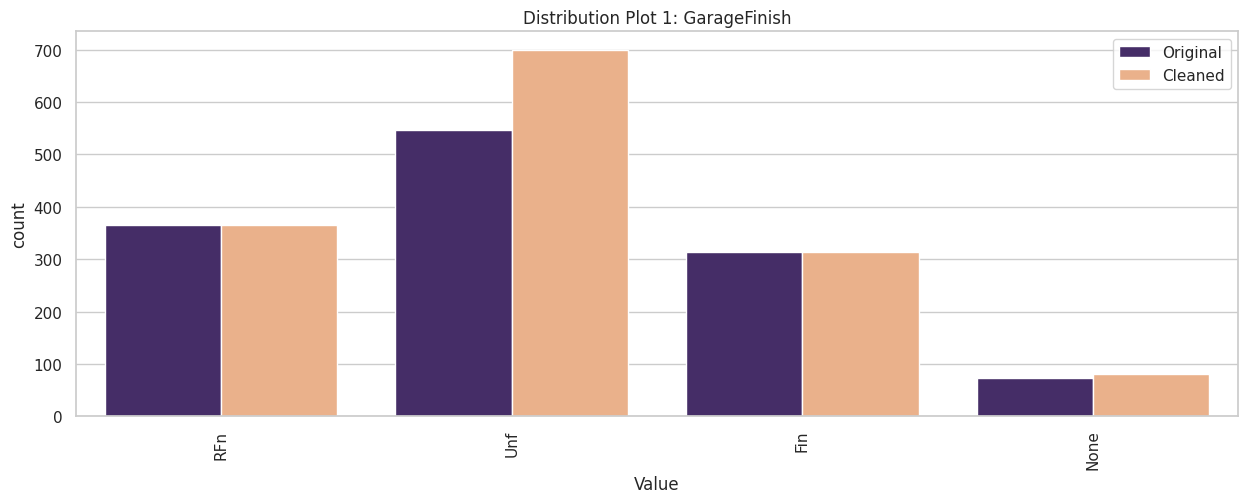

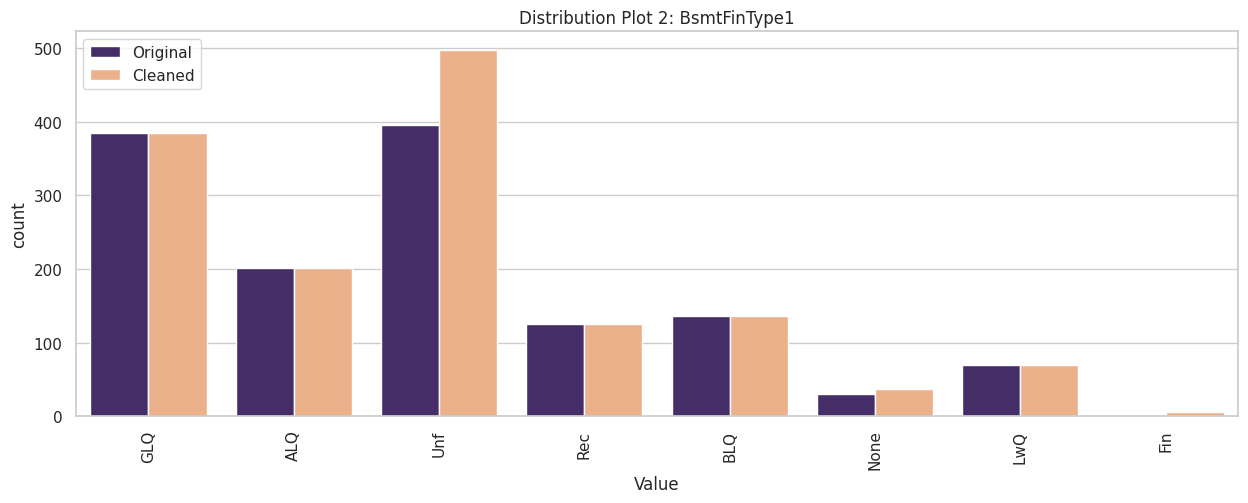

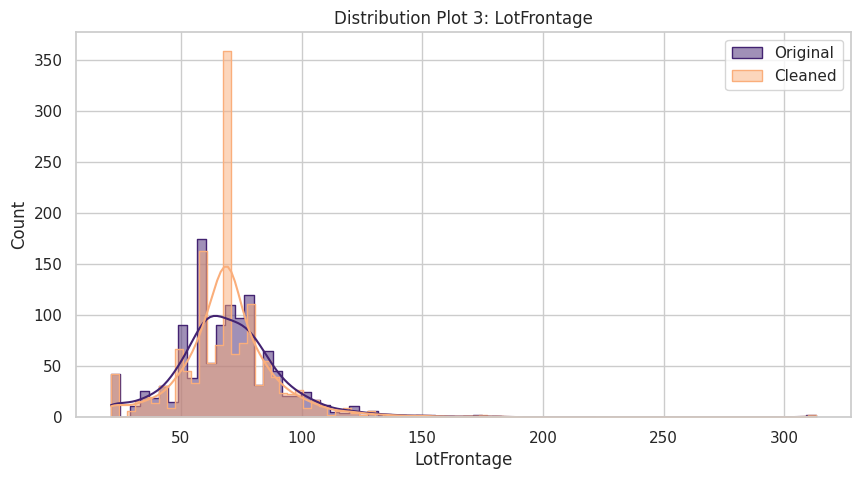

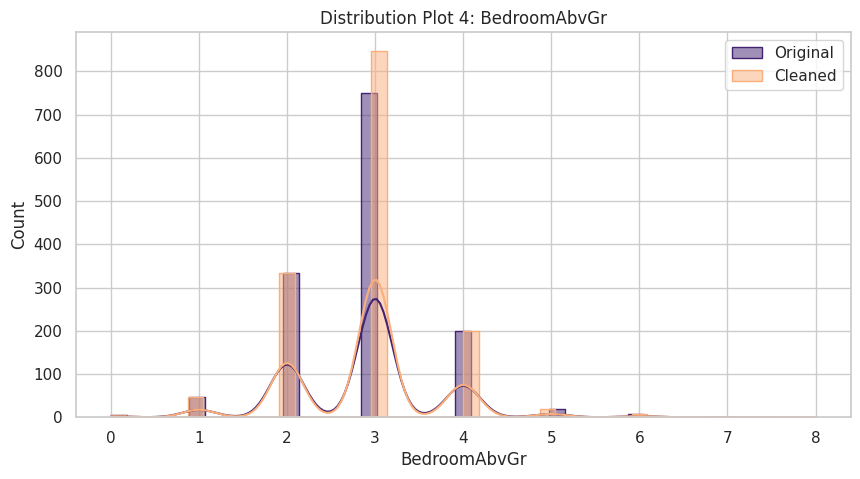

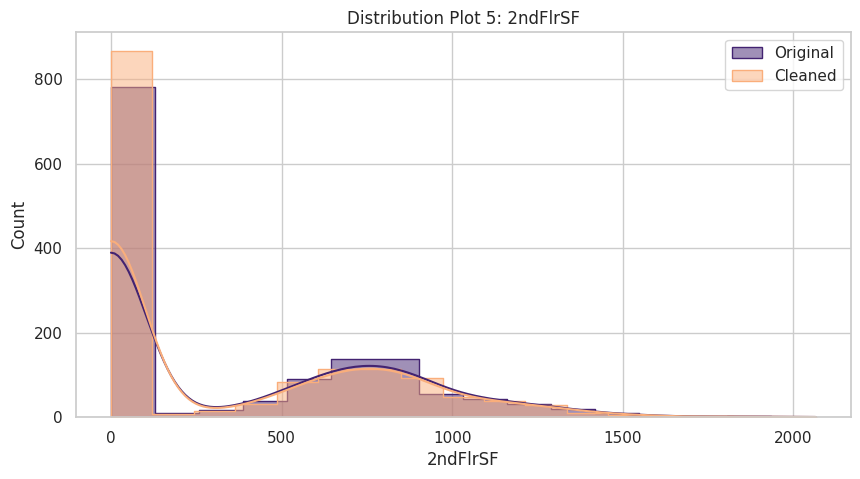

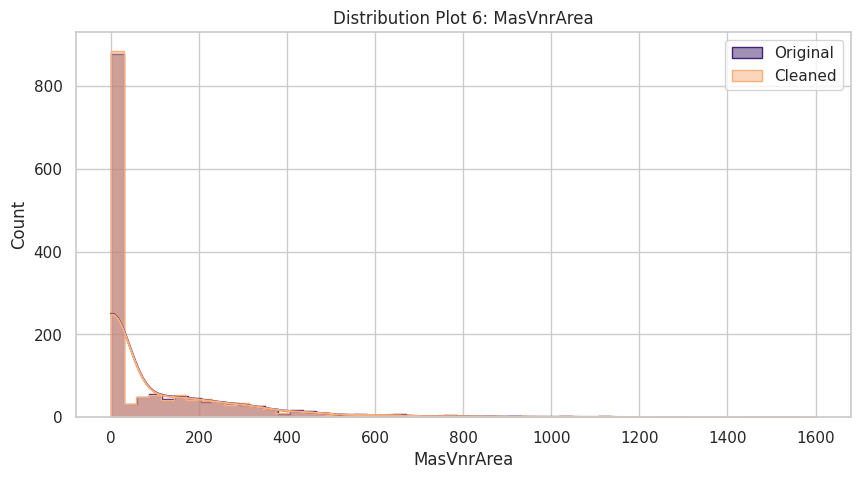

In [40]:
# List of variables that we want to analyze to see the effect of data cleaning
variables_to_analyze = [
    "GarageFinish", "BsmtFinType1", "LotFrontage", "BedroomAbvGr", "2ndFlrSF", "MasVnrArea"
]

# This function will display visual comparisons for each variable listed
# "df_original" refers to the DataFrame before any cleaning was applied
# "df_cleaned" refers to the DataFrame after cleaning operations have been performed
# "variables_applied_with_method" is a list of variable names that we want to compare
DataCleaningEffect(df_original=df, df_cleaned=df_cleaned, variables_applied_with_method=variables_to_analyze)

Now, we will verify that there are no remaining missing data points in our cleaned dataframe.

In [41]:
EvaluateMissingData(df_cleaned)

There are no variables with missing data


Since there is no more missing data, we can progress to the next step of splitting the cleaned dataset into training and test sets.

---

# Data Split

Next, we will split the cleaned dataframe into training and test sets:

In [42]:
from sklearn.model_selection import train_test_split
train_set, test_set, _, __ = train_test_split(
                                        df_cleaned,
                                        df_cleaned['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"train_set shape: {train_set.shape} \ntest_set shape: {test_set.shape}")

train_set shape: (1168, 21) 
test_set shape: (292, 21)


---

# Push files to Repo

Now that we have split the cleaned data into train and test sets, the following code creates an output directory and saves the train and test datasets into this directory:

In [43]:
import os

# Create the outputs/datasets/cleaned folder
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

# Save the Train Set in the created folder
train_set.to_csv("outputs/datasets/cleaned/train_set.csv", index=False)

# Save the Test Set in the created folder
test_set.to_csv("outputs/datasets/cleaned/test_set.csv", index=False)

# Save the Cleaned DataFrame
df_cleaned.to_csv("outputs/datasets/cleaned/df_cleaned.csv", index=False)

[Errno 17] File exists: 'outputs/datasets/cleaned'


---

# Conclusions and Next Steps

## Conclusions

**Dropped Variables**:
- **EnclosedPorch** and **WoodDeckSF** were removed due to a significant amount of missing data (over 89%).
- **GarageYrBlt** was dropped from the dataset due to its high correlation with **YearBuilt** and **YearRemodAdd**, suggesting redundancy.

**Imputation with Median Values**:
- **LotFrontage**: Imputed with the median due to its right-skewed distribution. The median provides a more robust central tendency measure in such cases.
- **BedroomAbvGr**: Missing values were filled with the median value (3), aligning with the typical property in the dataset.
- **MasVnrArea**: 0 was used to impute missing values, as a significant portion of this variable was already zero, indicating properties without masonry veneer.

**Categorical Variable Adjustments**:
- **BsmtFinType1**:
    - For properties with no basement area (**TotalBsmtSF** = 0), "None" was assigned.
    - Where the unfinished basement square footage (**BsmtUnfSF**) was greater than 0 but the finish type was missing, "Unf" (Unfinished) was imputed.
    - For properties with a finished basement but an unspecified finish type, a new category "Finished" was introduced.
- **GarageFinish**:
    - "None" was assigned to properties with 0 garage area but missing finish type, indicating no garage present.
    - "Unf" (Unfinished) was used to fill remaining missing values, as it is the most common condition among properties with garages.

**Final Validation**:
- Verified the absence of any remaining missing data within the dataset.
- Ensured that the train and test sets were properly split and saved, along with the complete cleaned dataset.



## Next Steps

Having completed the data cleaning process, the next step will be feature engineering.